In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (24,24)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import imageio

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255                           ## to convert float values to image pixel values
    tensor = np.array(tensor, dtype=np.uint8)     ## convert it into np array with int values
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1               ## if the array has 3 dim but 1st dim is only 1 then we remove it
        tensor = tensor[0]
    
    return PIL.Image.fromarray(tensor)            ## return an image from the array

In [3]:
## Downloading a style and content image:

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Visualising the input

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)              ## read the image in a tensor form
    img = tf.image.decode_image(img, channels=3)    ## convert the tensor from the path to an image
    img = tf.image.convert_image_dtype(img, tf.float32)   ## convert image from int [0 to 255] to float [0 to 1)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)  ## type casting shape from int to float
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)     ## scaling down the image shape to 512 max dim..

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]                        ## adding a new axis
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)       ## reducing the 1 extra axis added

    plt.imshow(image)
    if title:
        plt.title(title)

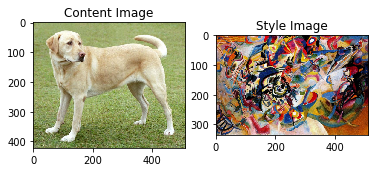

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub 

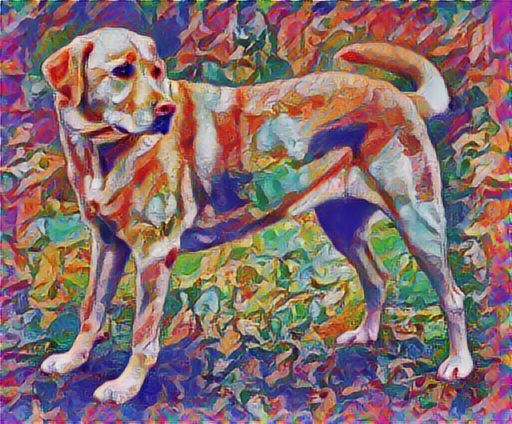

In [7]:
## Using hub on pretrained module to get the result image. 

import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]   ## takes the images as tensors
tensor_to_image(stylized_image)

## Define content and style representations

In [8]:
## Loading a VGG19 CNN model to predict the content image
## Use the intermediate layers of the model to get the content and style representations of the image.

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)     ## converting image to int from float
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')  ## loading a VGG19 with imagenet weights
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

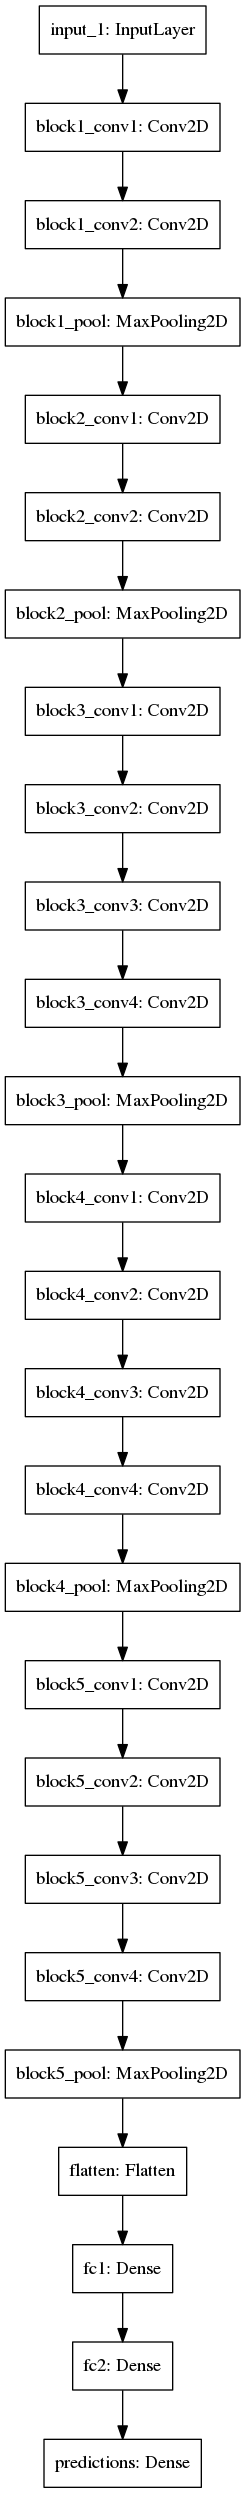

In [9]:
tf.keras.utils.plot_model(vgg, to_file='VGG19.png')

In [10]:
## printing the top 5 probabilites

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317262),
 ('golden_retriever', 0.23665187),
 ('kuvasz', 0.036357313),
 ('Chesapeake_Bay_retriever', 0.024182774),
 ('Greater_Swiss_Mountain_dog', 0.018646035)]

In [11]:
## Loading a VGG19 Model with imagenet weights.

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
## Choose intermediate layers from the network to represent the style and content of the image:

# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model

In [13]:
## For the functional API keras has model = Model(input,output)

def vgg_layers(layer_names):

    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]      ## returning a list of intermediate oputputs

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [14]:
## Creating the Model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8867
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.133
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2532
  mean:  59.179478



## Calculate Style

In [15]:
## The content of an image is represented by the values of the intermediate feature maps.
## It turns out, the style of an image can be described by the means and correlations across the different 
## feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature
## vector with itself at each location, and averaging that outer product over all locations. 

In [16]:
def gram_matrix(input_tensor):

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)   ## func to implement gram matrix
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return result/(num_locations)

## Extract style and content

In [17]:
## Build a model that returns the style and content tensors.
## When called on an image, this model returns the gram matrix (style) of the style_layers and 
## content of the content_layers

class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):

        inputs = inputs*255.0                        ## Expects float input in [0,1] converting it to int
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict} 

In [18]:
## With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating
## the mean square error for your image's outputrelative to each target, then take the weighted sum of these losses.

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):

    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):

    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522847
    max:  28014.559
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.49
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.86

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.38
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764152


## Run gradient descent

In [44]:
## Set your style and content target values from the given images:

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [45]:
image = tf.Variable(content_image) ## making the image a tensor var to be executed.

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0) # since this is float values lie b/w [0,1]


In [46]:
## Setting the optimizer

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

## To optimize this, use a weighted combination of the two losses to get the total loss:

style_weight=1e-2
content_weight=1e4

In [47]:
def style_content_loss(outputs):
    
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) ## sqrt mean
                           for name in style_outputs.keys()])         ## add_n Adds all input tensors element-wise.
    style_loss *= style_weight / num_style_layers                     ## updatin the loss

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss                                  ## Total loss
    return loss

In [48]:
## Use tf.GradientTape to update the image.

@tf.function()
def train_step(image):
    
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)             ## gradiating loss wrt image
    opt.apply_gradients([(grad, image)])          ## It returns an `Operation` that applies gradients.

    image.assign(clip_0_1(image))                 ## converting image to tensor

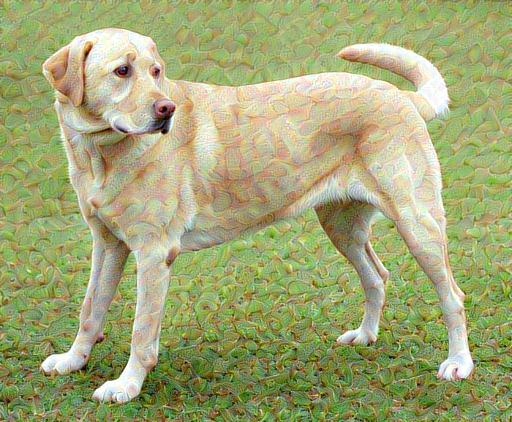

In [49]:
## Test-running the image for a few steps:

train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)


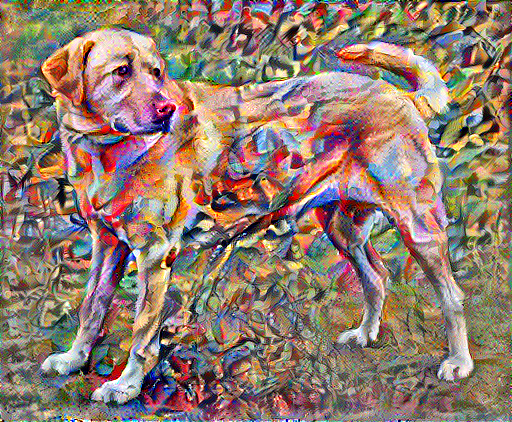

Train step: 1000
Total time: 3565.6


In [50]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0

for n in range(epochs):
    
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    print(".", end='')
    display.clear_output(wait=True)
    result = tensor_to_image(image)
    display.display(result)
    result.save('result_images/{}-epoch.jpg'.format(n))
    
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [54]:
from images2gif import writeGif
from PIL import Image
import os

file_names = sorted((fn for fn in os.listdir('.') if fn.endswith('.png')))
#['animationframa.png', 'animationframb.png', 'animationframc.png', ...] "

images = [Image.open(fn) for fn in file_names]

print(writeGif.__doc__)
# writeGif(filename, images, duration=0.1, loops=0, dither=1)
#    Write an animated gif from the specified images.
#    images should be a list of numpy arrays of PIL images.
#    Numpy images of type float should have pixels between 0 and 1.
#    Numpy images of other types are expected to have values between 0 and 255.


#images.extend(reversed(images)) #infinit loop will go backwards and forwards.

filename = "my_gif.GIF"
writeGif(filename, images, duration=0.2)

ImportError: No module named 'images2gif'

## Total variation loss